<a href="https://colab.research.google.com/github/ayyucekizrak/Mechanistic-Interpretability/blob/main/induction_head_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Necessary Libraries**

In [1]:
# Install necessary libraries
!pip install transformer-lens circuitsvis

**Import Libraries**

In [2]:
# Import necessary libraries
import os
import torch as t
import numpy as np
from pathlib import Path
from transformer_lens import HookedTransformer, FactoredMatrix, ActivationCache
import circuitsvis as cv
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

**Set Device**

In [3]:
# Set device to GPU if available
device = t.device("cuda" if t.cuda.is_available() else "cpu")

**Load Pre-trained Model**

In [4]:
# Load a pre-trained GPT-2 model using TransformerLens
model = HookedTransformer.from_pretrained("gpt2-small").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


**Define Input Sequences**

In [5]:
# Sample input sequences with repeating patterns
sequences = [
    "the cat sat on the mat",
    "the cat sat the cat sat",
    "the quick brown fox jumps over the lazy dog",
    "the quick brown fox jumps the quick brown fox jumps"
]

**Tokenize Input Sequences**

In [6]:
# Tokenize sequences
tokenized_sequences = [model.to_tokens(seq).to(device) for seq in sequences]

**Define Function for Dynamic Threshold Detection**

In [7]:
def dynamic_threshold_detection(activations):
    """
    Function to detect induction heads using dynamic thresholding.
    Args:
        activations: A list of attention patterns.
    Returns:
        detection_scores: Scores indicating the presence of induction heads.
        thresholds: Dynamic thresholds calculated based on attention variance.
    """
    thresholds = []
    detection_scores = []
    for act in activations:
        # Calculate attention variance and set dynamic threshold
        attention_variance = t.var(act, dim=-1).mean().item()
        threshold = attention_variance * 0.5  # Example thresholding logic
        thresholds.append(threshold)

        # Simple heuristic: High attention to previous tokens in repeating sequences indicates induction
        avg_attention = act.mean(dim=-2)  # Average over heads
        score = avg_attention.diagonal(offset=1).mean().item()  # Score based on attention to previous token
        detection_scores.append(score)
    return detection_scores, thresholds

**Extract Attention Activations**

In [8]:
# Extract attention activations
activations = []
for tokens in tokenized_sequences:
    _, cache = model.run_with_cache(tokens)
    # Access the attention patterns for the last layer and all heads
    attn_pattern = cache["blocks.11.attn.hook_pattern"]
    activations.append(attn_pattern)

**Detect Induction Heads Using Dynamic Thresholding**

In [9]:
# Detect induction heads using dynamic thresholding
predicted_scores, thresholds = dynamic_threshold_detection(activations)
predicted_labels = [1 if score > threshold else 0 for score, threshold in zip(predicted_scores, thresholds)]

**Define True Labels for Evaluation**

In [10]:
# Dummy true labels for demonstration (1 = induction head, 0 = not)
true_labels = [0, 1, 0, 1]

**Calculate Evaluation Metrics**

In [11]:
# Calculate evaluation metrics
precision = precision_score(true_labels, predicted_labels, zero_division=1)
recall = recall_score(true_labels, predicted_labels, zero_division=1)
f1 = f1_score(true_labels, predicted_labels, zero_division=1)

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


Precision: 0.5, Recall: 1.0, F1-Score: 0.6666666666666666


**Visualize Attention Patterns**

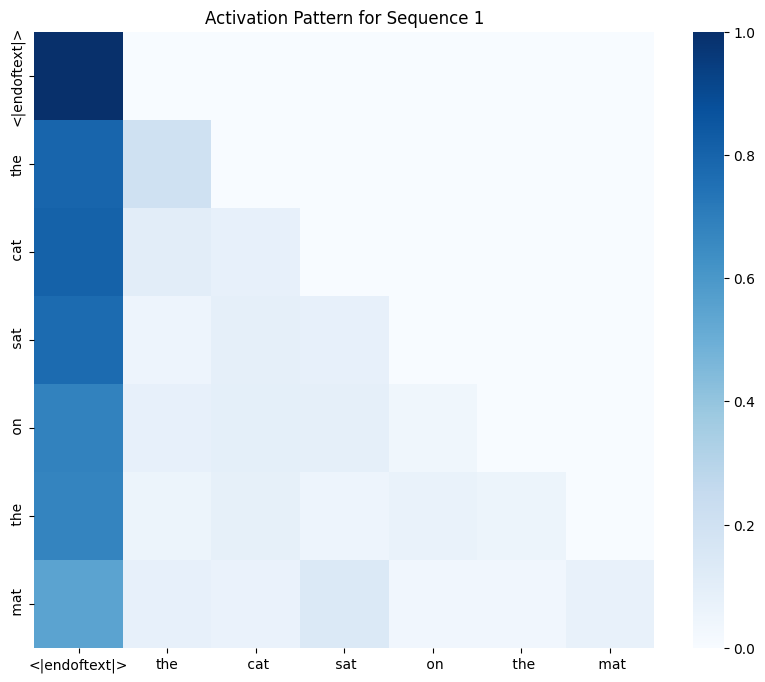

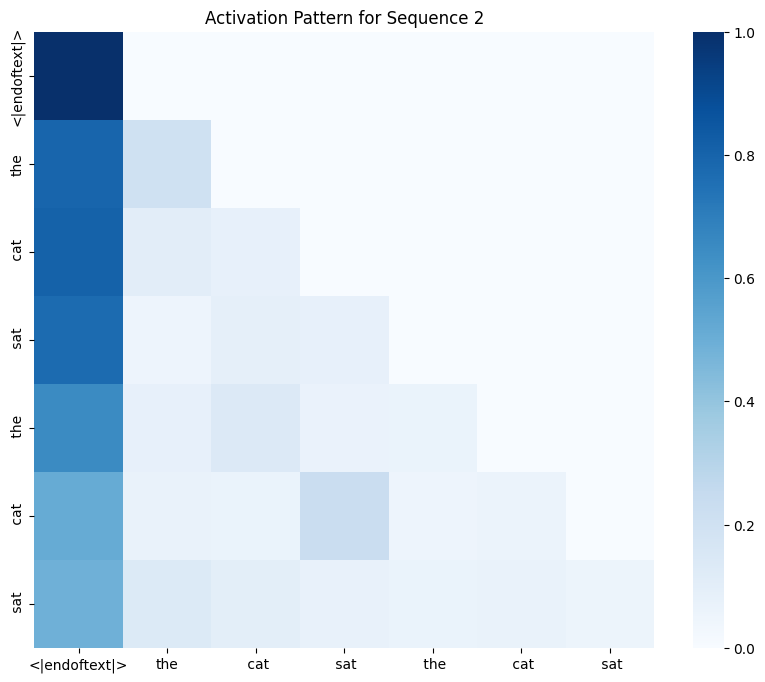

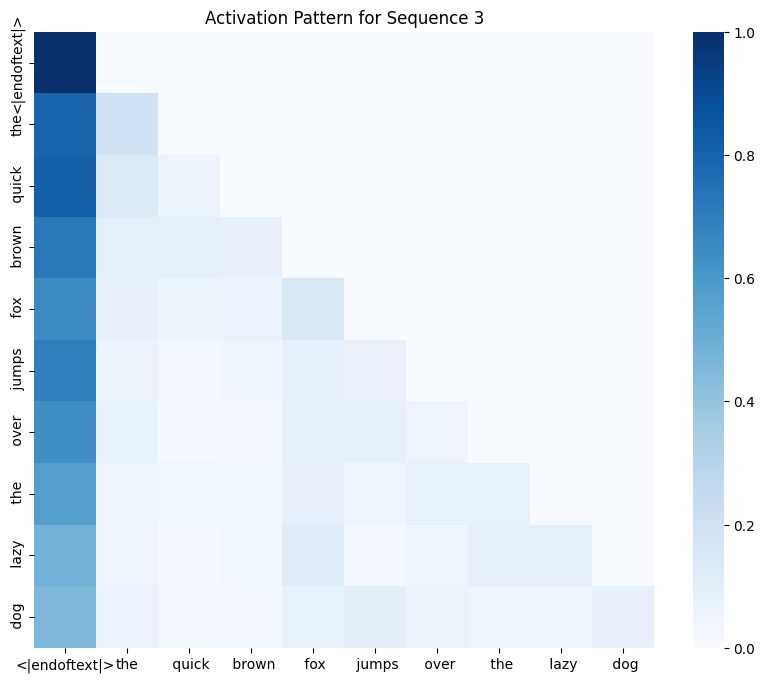

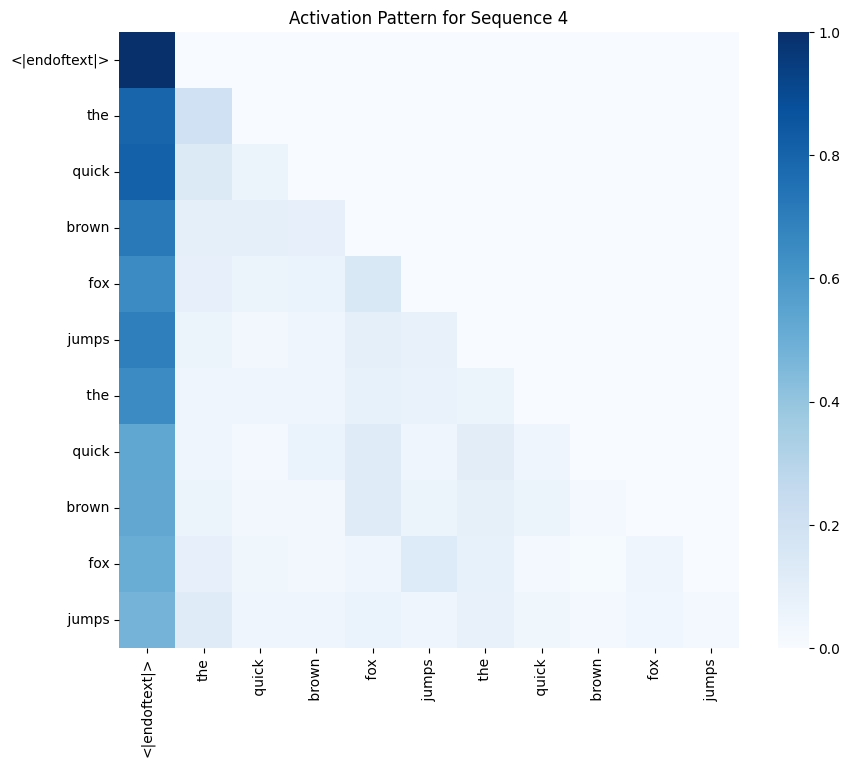

In [12]:
# Visualize attention patterns using matplotlib
for i, pattern in enumerate(activations):
    # Reduce the dimensions to 2D by selecting one head or averaging across heads
    attention_matrix = pattern.mean(dim=1)[0].cpu().detach().numpy()  # Select the first head after averaging across heads
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, annot=False, cmap='Blues',
                xticklabels=model.to_str_tokens(tokenized_sequences[i]),
                yticklabels=model.to_str_tokens(tokenized_sequences[i]))
    plt.title(f"Activation Pattern for Sequence {i+1}")
    plt.show()


### Visualize Attention Patterns Using Plotly

In [13]:
!pip install plotly

In [14]:
import plotly.graph_objects as go

def plot_attention_heatmap(tokens, attention_matrix, sequence_idx):
    """
    Plots an interactive attention heatmap using Plotly.
    Args:
        tokens: The tokens in the sequence.
        attention_matrix: The attention matrix for the sequence.
        sequence_idx: The index of the sequence being visualized.
    """
    fig = go.Figure(data=go.Heatmap(
        z=attention_matrix,
        x=tokens,
        y=tokens,
        colorscale='Blues'
    ))

    fig.update_layout(
        title=f'Interactive Attention Pattern for Sequence {sequence_idx+1}',
        xaxis_nticks=len(tokens),
        yaxis_nticks=len(tokens),
        xaxis_title='Tokens',
        yaxis_title='Attention on Tokens',
        autosize=True,
    )

    fig.show()

# Visualize attention patterns using Plotly
for i, pattern in enumerate(activations):
    # Reduce the dimensions to 2D by selecting one head or averaging across heads
    attention_matrix = pattern.mean(dim=1)[0].cpu().detach().numpy()  # Select the first head after averaging across heads
    tokens = model.to_str_tokens(tokenized_sequences[i])

    # Call the Plotly heatmap visualization
    plot_attention_heatmap(tokens, attention_matrix, i)


### Enhanced Visualization Using `matplotlib` and `seaborn`

**1.   Attention Heatmap:**
*   This function visualizes the average attention pattern across all heads for a given layer as a heatmap. Each row corresponds to a query position (token), and each column represents a key position (token).
*   The brighter the cell, the more attention is being paid to that position, indicating how much one token attends to another.

**2.   Line Plot for Attention Scores:**
*   For each query token, a line plot shows the distribution of attention scores across key positions.
*   This visualization helps in understanding how the attention is distributed among different tokens for each query position.

**3.   Visualization Features:**
*   **Enhanced Heatmap:** Custom color maps and larger figure sizes for better visibility.
*   **Interactive Legends:** Legends for each query token showing attention distribution across key tokens.
*   **Annotations:** Titles and labels for better interpretability.

**4.  Usage Notes**
*  **Layer Selection:** You can change the `layer` parameter to visualize attention patterns for different layers.
*  **Token Visualization:** Use the `model.to_str_tokens()` function to visualize the attention patterns for human-readable tokens.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu
Visualizing Attention for Sequence 1:


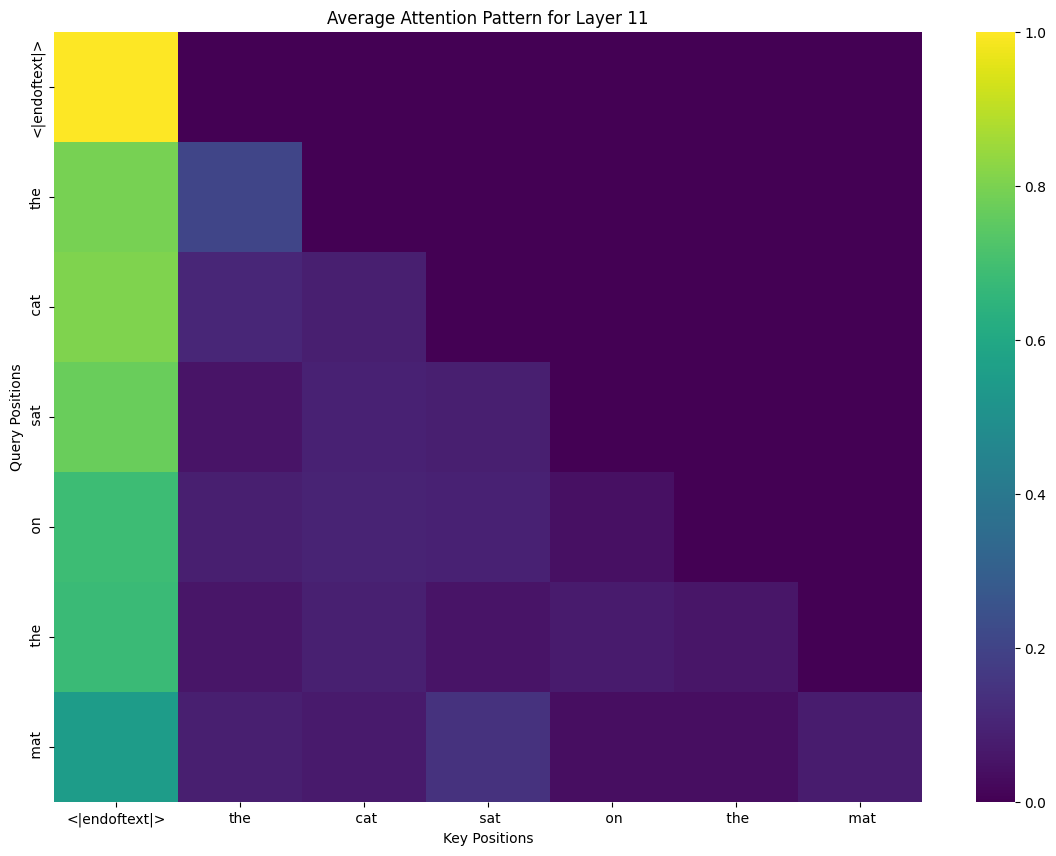

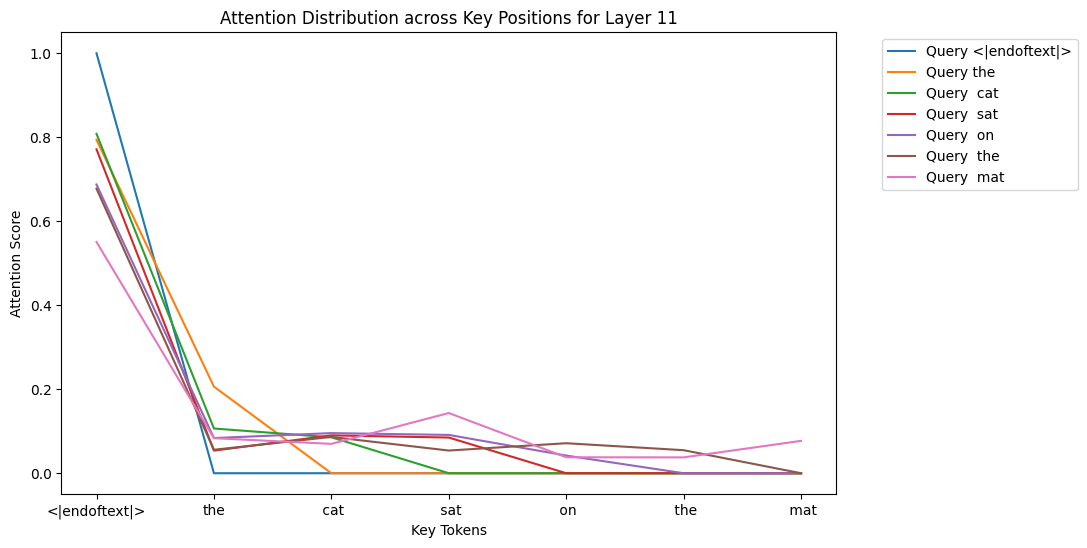

Visualizing Attention for Sequence 2:


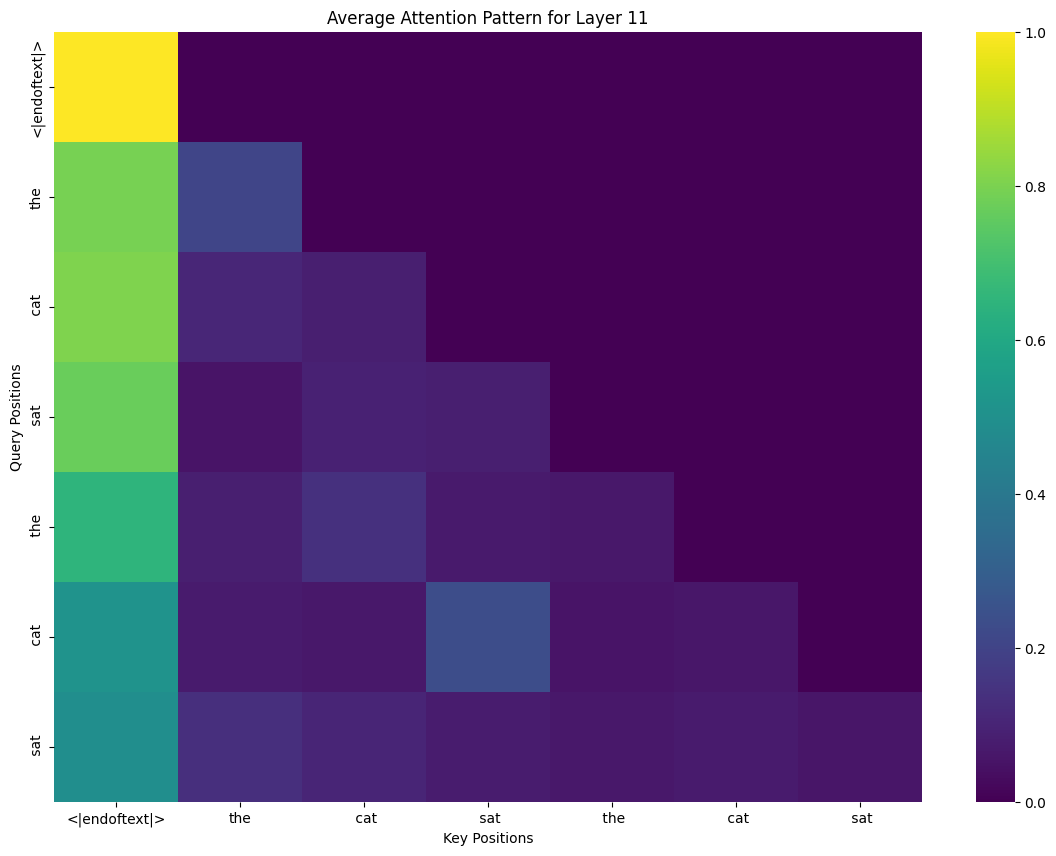

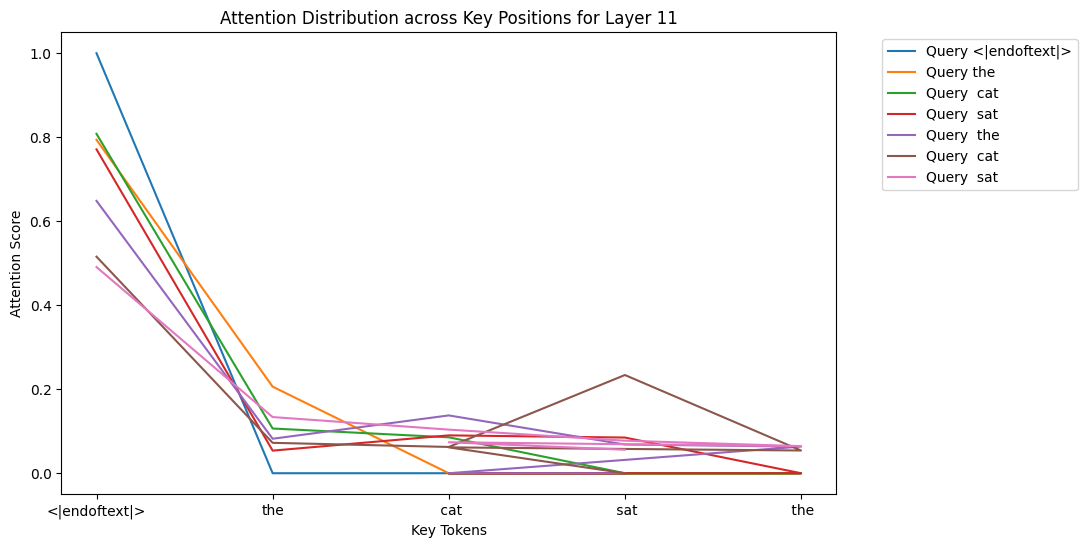

Visualizing Attention for Sequence 3:


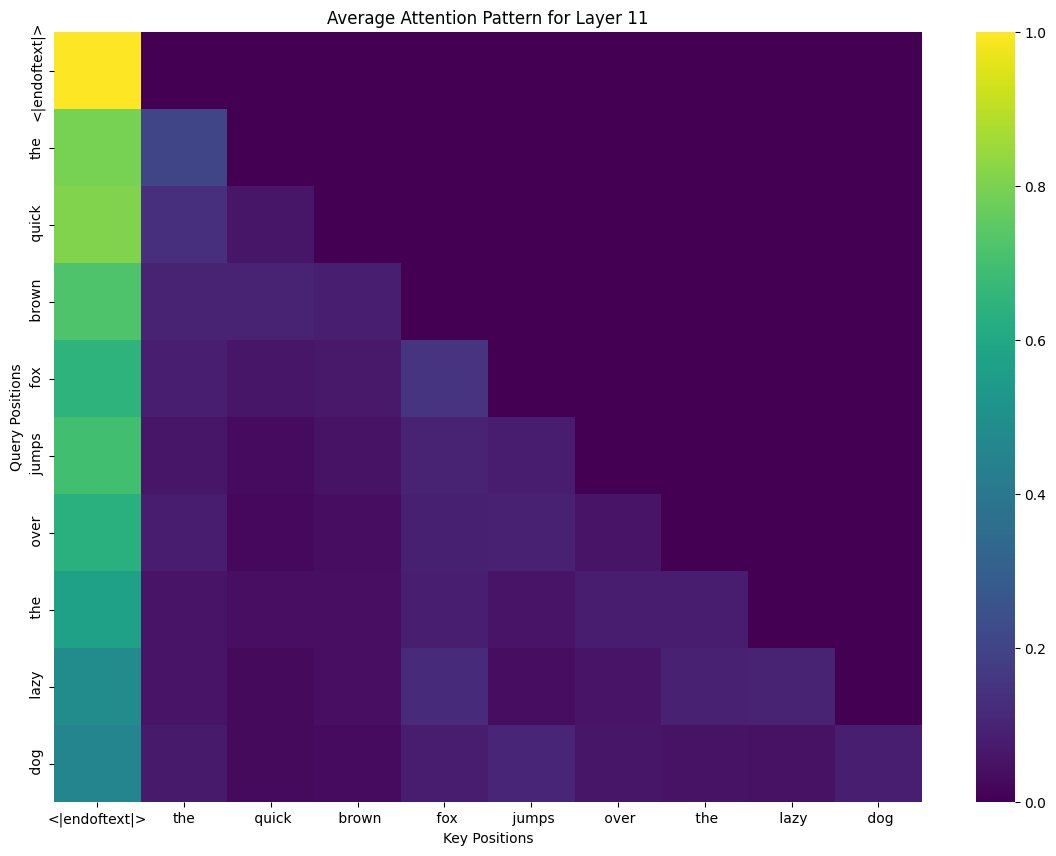

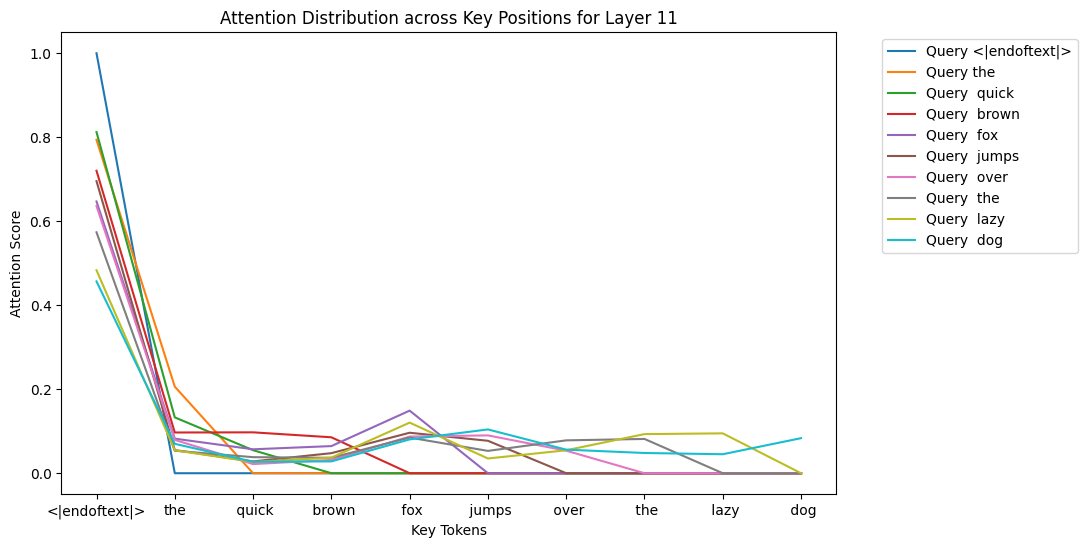

Visualizing Attention for Sequence 4:


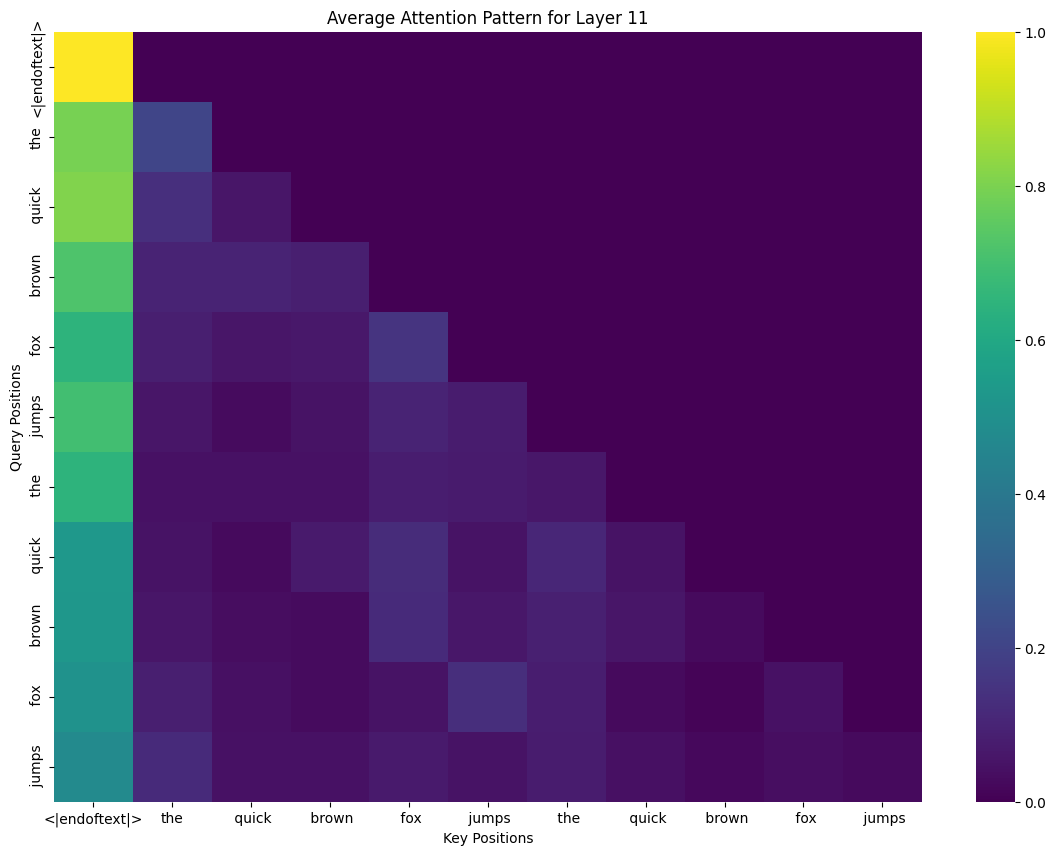

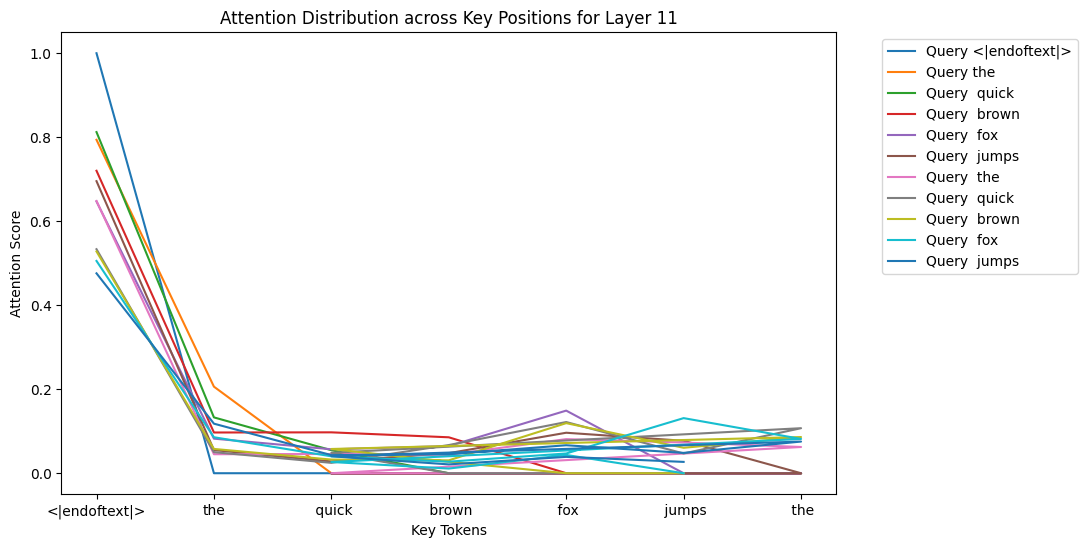

In [28]:
# Install necessary libraries
!pip install transformer-lens circuitsvis matplotlib seaborn

# Import necessary libraries
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformer_lens import HookedTransformer

# Set device to GPU if available
device = t.device("cuda" if t.cuda.is_available() else "cpu")

# Load a pre-trained GPT-2 model using TransformerLens
model = HookedTransformer.from_pretrained("gpt2-small").to(device)

# Sample input sequences with repeating patterns
sequences = [
    "the cat sat on the mat",
    "the cat sat the cat sat",
    "the quick brown fox jumps over the lazy dog",
    "the quick brown fox jumps the quick brown fox jumps"
]

# Tokenize sequences
tokenized_sequences = [model.to_tokens(seq).to(device) for seq in sequences]

# Function to visualize attention patterns as heatmaps with line plots
def visualize_attention_patterns(tokens, model, layer=11):
    # Run the model with cache to get attention patterns
    _, cache = model.run_with_cache(tokens)
    attn_weights = cache[f"blocks.{layer}.attn.hook_pattern"][0].cpu().detach().numpy()  # Shape: [Heads, QueryPos, KeyPos]

    # Calculate the average attention across heads
    avg_attn = attn_weights.mean(axis=0)  # Shape: [QueryPos, KeyPos]
    tokens_str = model.to_str_tokens(tokens)

    # Plotting the average attention as a heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(avg_attn, annot=False, cmap='viridis', xticklabels=tokens_str, yticklabels=tokens_str)
    plt.title(f"Average Attention Pattern for Layer {layer}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

    # Additional line plot to visualize the sum of attention across key positions for each query
    plt.figure(figsize=(10, 6))
    for query_idx in range(avg_attn.shape[0]):
        plt.plot(tokens_str, avg_attn[query_idx], label=f"Query {tokens_str[query_idx]}")
    plt.title(f"Attention Distribution across Key Positions for Layer {layer}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Attention Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Visualize the attention patterns for each sequence in a specific layer
for i, tokens in enumerate(tokenized_sequences):
    print(f"Visualizing Attention for Sequence {i+1}:")
    visualize_attention_patterns(tokens, model, layer=11)
